# Description

This notebook loads the pre-trained model by Erik Wallin and evaluates the performance on the given test set without training.

I adjusted the columns of the train/test set to match the data on which the pre-trained model was trained but the distribution of the two datasets is different. Hence, the expected conclusion is that the performance of the pre-trained model should not be good.


In [1]:
%matplotlib inline
import sys
BIN = 'utils/'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')


In [2]:
from nn_utils import AE_3D_200
from utils import plot_activations

In [3]:
torch.cuda.is_available()

True

In [4]:
fastai.torch_core.defaults.device = 'cuda'

### Load the data

In [5]:
# Load data
train = pd.read_pickle('../datasets/all_jets_train_4D_100_percent.pkl').astype(np.float32)
test = pd.read_pickle('../datasets/all_jets_test_4D_100_percent.pkl').astype(np.float32)
n_features = len(train.loc[0])

train.head(10)

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871
61832,6236.774414,30013.537109,-2.962712,0.091814
26867,17774.943359,205705.046875,2.472530,-1.299140
46232,4181.291992,20511.900391,-1.937396,-1.893408
44194,4537.854492,29095.220703,2.703056,-1.746550
59782,6769.761719,26334.353516,1.344461,-2.599911


## Change sequence of columns according to the pretrained model

#### Assumption: I have assumed that 'm' is 'E' as mentioned in the original code. If it is not, then the results of this notebook are invalid.

In [6]:
train = train[['pt', 'eta', 'phi', 'm']]
test = test[['pt', 'eta', 'phi', 'm']]
train


,pt,eta,phi,m
132784,22000.609375,1.142924,1.567018,3831.839355
99666,21648.210938,0.213654,-2.680558,4582.417480
26629,169514.281250,1.163296,-1.948239,16747.765625
80473,183085.609375,2.670927,-1.641102,14789.586914
48229,20527.130859,-1.158871,2.922270,4646.724121
...,...,...,...,...
53491,24546.789062,1.652488,-2.150104,4953.317871
106817,101725.289062,1.593228,2.439408,13648.668945
61324,24144.490234,1.522092,1.226542,5574.332520
132003,23436.962891,1.151906,-2.397882,4341.430664


In [7]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

In [8]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [9]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

In [10]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [11]:
db

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7fa99c70a240>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7fa935be2898>;

Test: None

In [12]:
model = AE_3D_200()

In [13]:
loss_func = nn.MSELoss()

In [14]:
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, bn_wd=bn_wd, true_wd=true_wd)

### Load the pre-trained model

In [15]:
learn.load('AE_3D_200_no1cycle_trainforever')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7fa99c70a240>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7fa935be2898>;

Test: None, model=AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=1e-06, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, 

### Evaluate on the test set

In [16]:
learn.validate()

[0.18641578]

In [17]:
curr_save_folder = 'plots/trainforever_plots/'

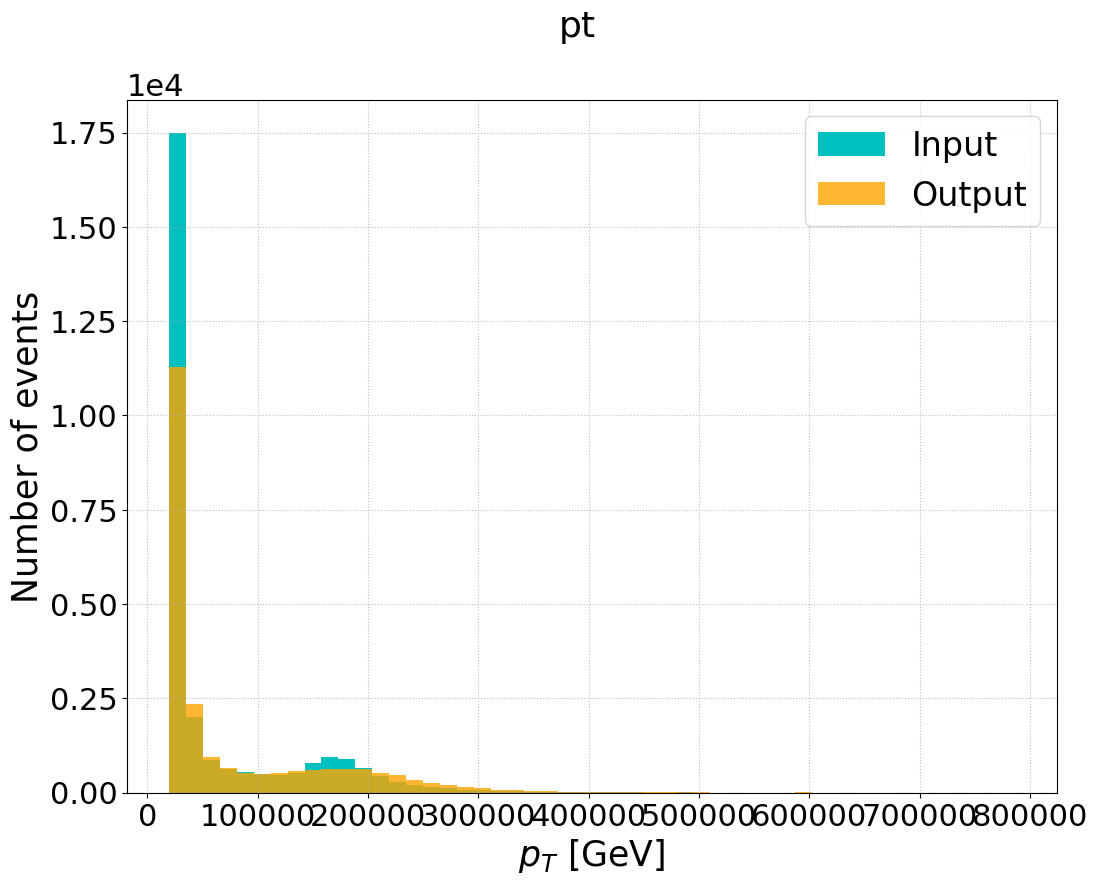

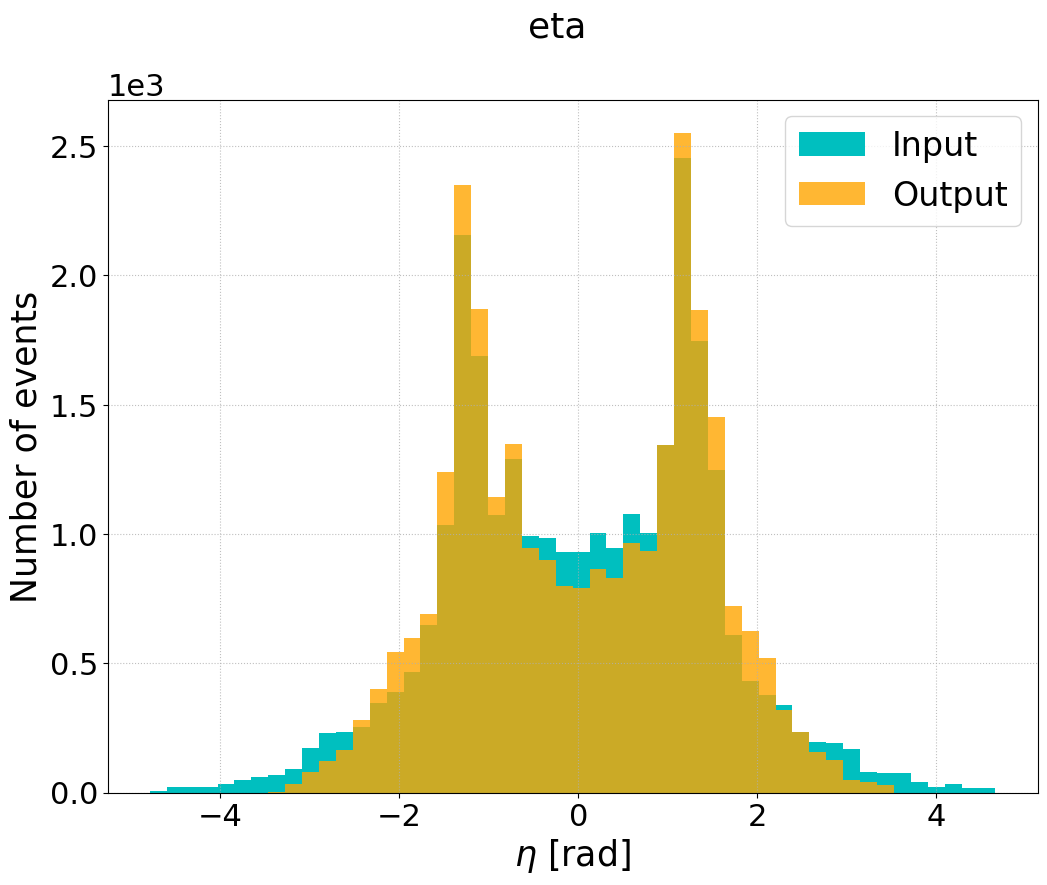

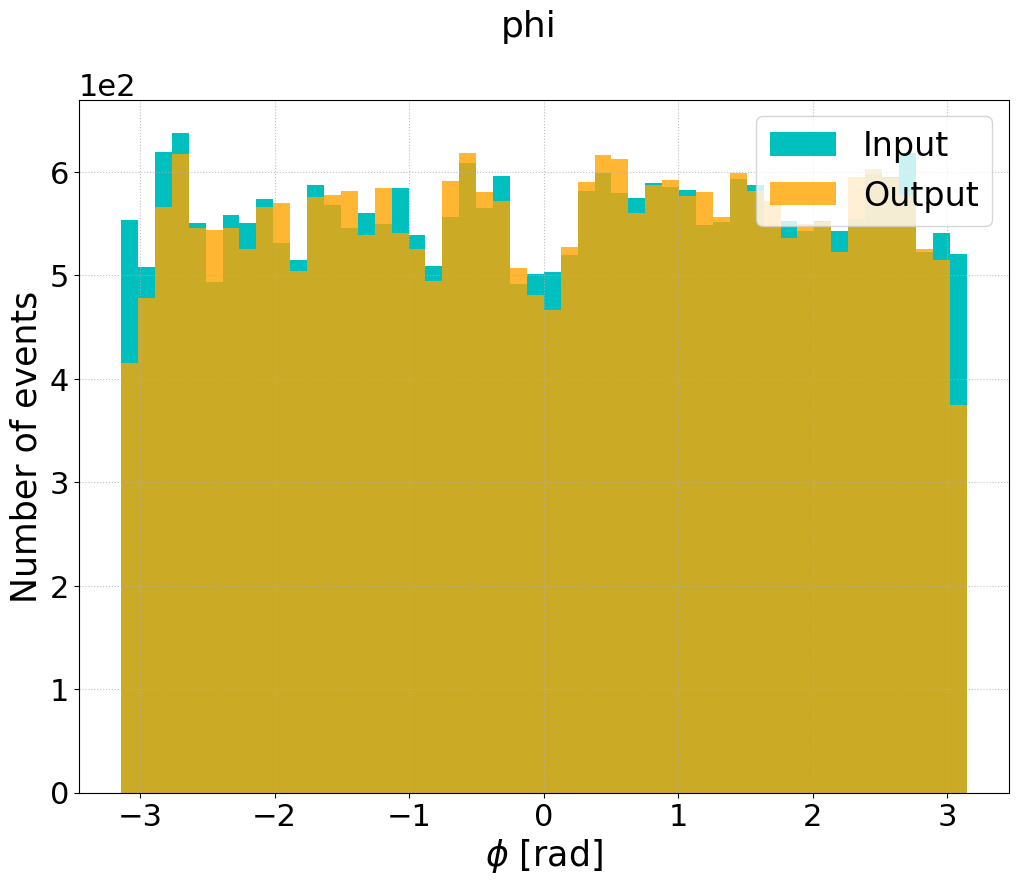

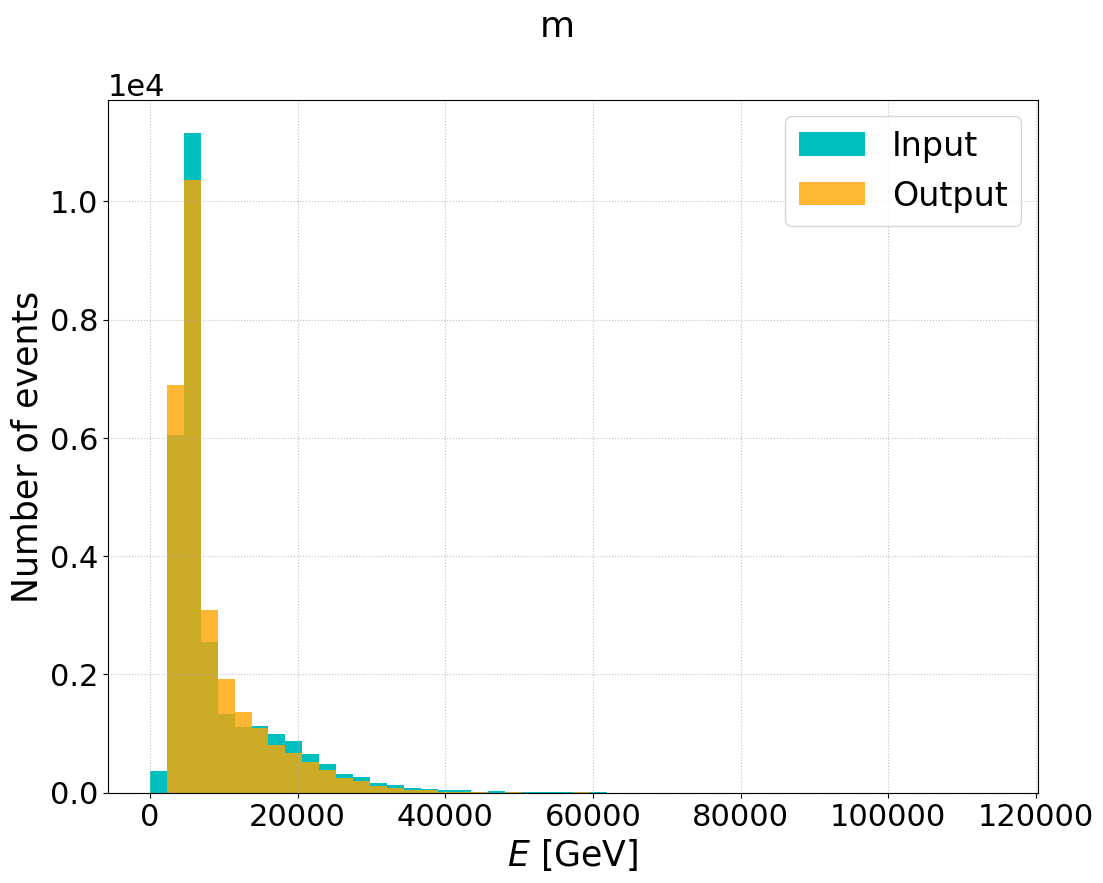

In [19]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

pt Mean:  -0.02757439 \pm 0.0021096716322606484  Sigma:  0.3526624 \pm 0.0014917365182361825
eta Mean:  0.13439687 \pm 0.04241758814647472  Sigma:  7.090719 \pm 0.02999322971847272
phi Mean:  -0.08984978 \pm 0.10284466106725086  Sigma:  17.191986 \pm 0.07272085831004511
m Mean:  3440.213 \pm 473.2924180555954  Sigma:  79117.734 \pm 334.6622969091388


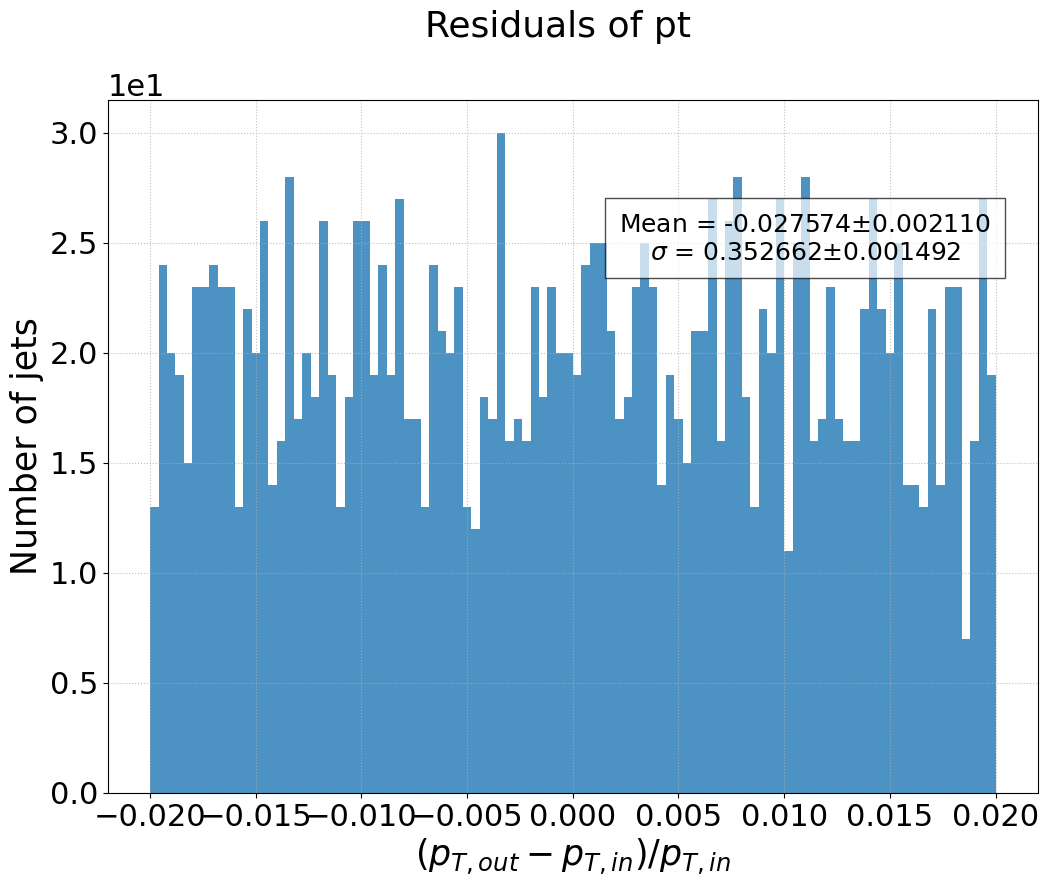

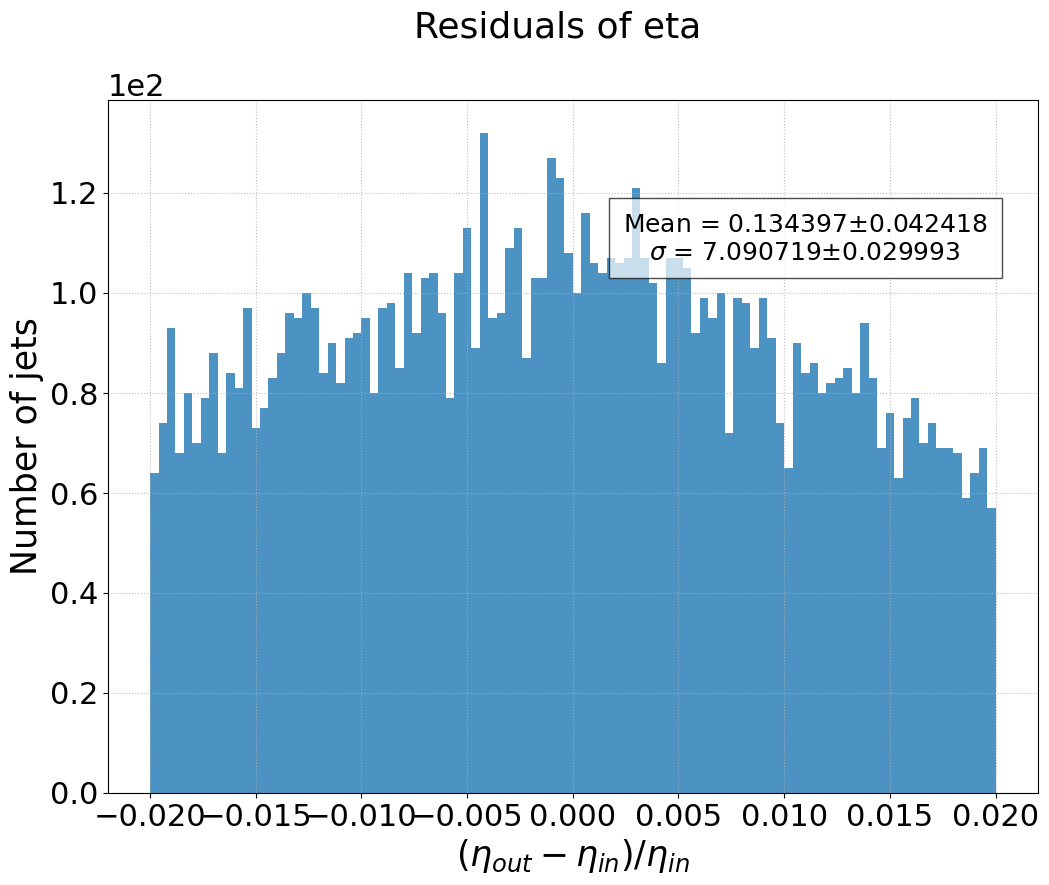

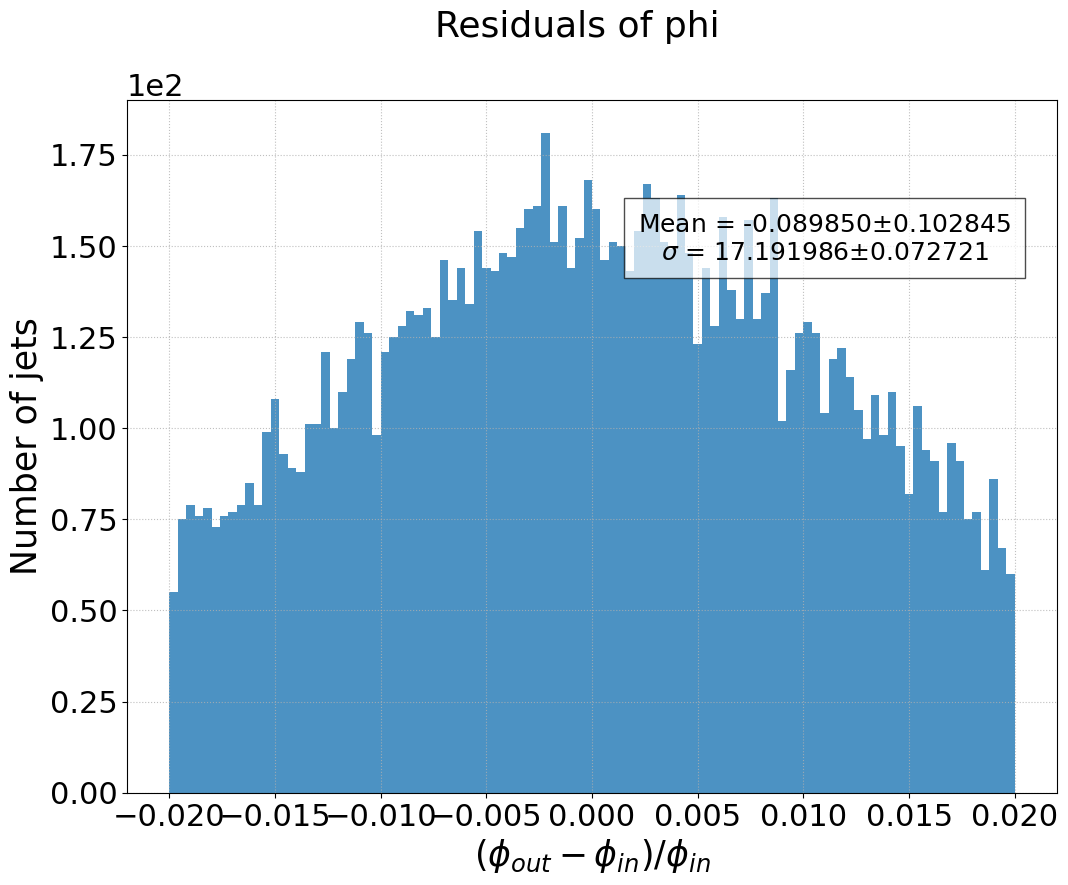

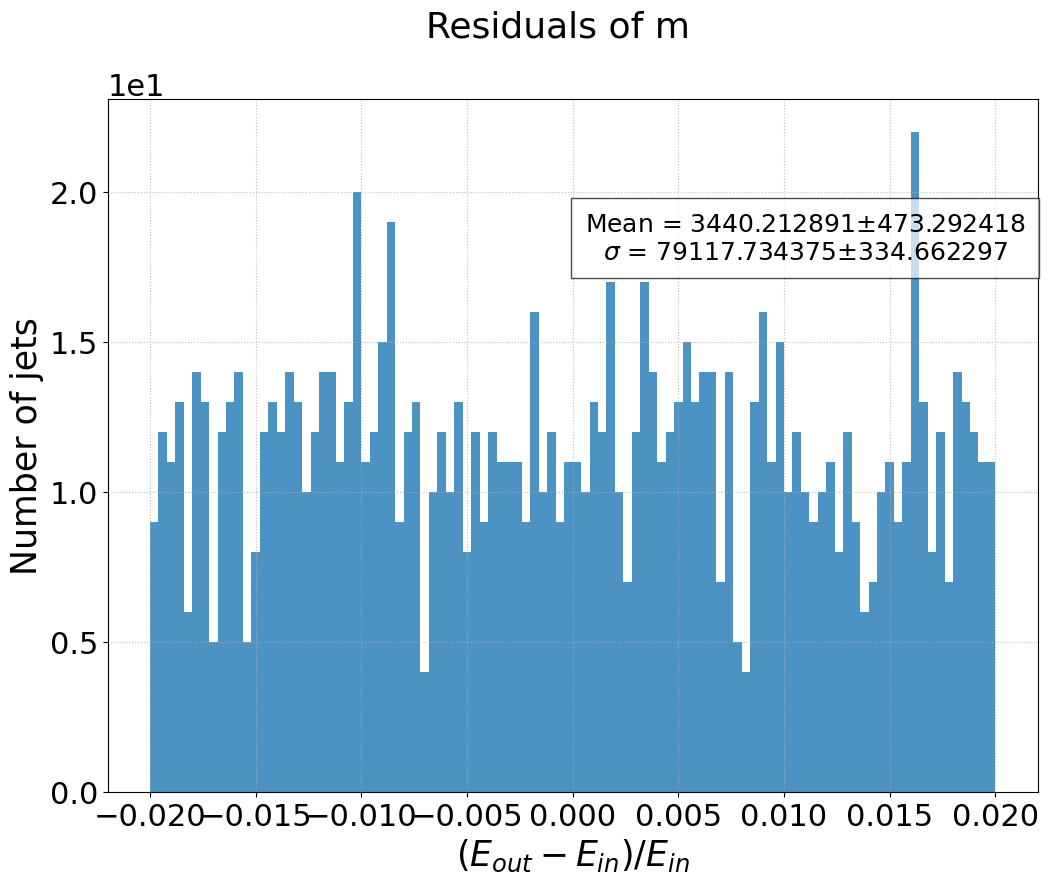

In [20]:
import utils
from scipy import stats
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']

data = data.detach().numpy()
data[:,3][(data[:,3]<1e-3)] += 1
residuals = (pred - data) / data
range = (-.02, .02)
#range=None
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    print(train.columns[kk],'Mean: ', mean, '\pm', sem, ' Sigma: ', std, '\pm', std_err )
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

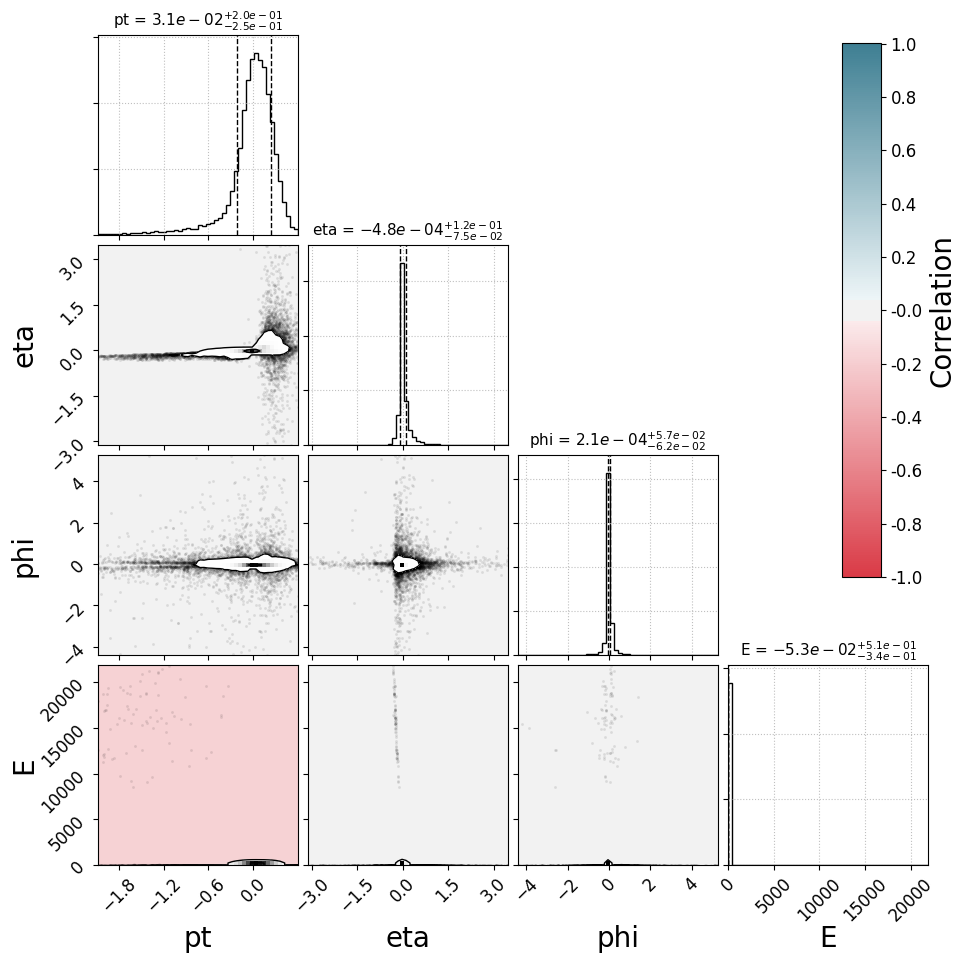

In [21]:
import corner.corner as corner
import seaborn as sns

res_df = pd.DataFrame({'pt': residuals[:, 0], 'eta': residuals[:, 1], 'phi': residuals[:, 2], 'E': residuals[:, 3]})
save = False

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['pt', 'eta', 'phi', 'E']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = 'corner_3d.png'
    plt.savefig(curr_save_folder + fig_name)

## Conclusion

#### These plots show that a model trained on one dataset does not work well on another dataset having different distribution or even scale. It can be fine-tuned on the current dataset but if sufficient data is available, training from scratch should be better, depending on the difference between data distributions.